In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tdm_loader
import cv2
from wavelets import WaveletAnalysis
%matplotlib inline

# 1. Preprocessing (from Clipped data)

In [2]:
class SemblexData:
    def __init__(self, data_root):
        self.data_root = data_root
        all_folders = []
        for day in os.listdir(data_root):
            data_dir = os.path.join(data_root, day, '')
            folders = [[folder+file+'/' for file in os.listdir(folder)] for folder in [data_dir + f+'/' for f in os.listdir(data_dir)]]
            all_folders.append(folders)
            
        all_clipped_files = []
        for day in all_folders:
            for data_type in day:
                for cond_dir in data_type:
                    for file in os.listdir(cond_dir):
                        if file.find('.npy') > -1 and 'raw' in file: 
                            all_clipped_files.append(os.path.join(cond_dir, file))
        self.all_folders = all_folders
        self.all_clipped_files = all_clipped_files
        for i, clipped_file in enumerate(all_clipped_files):
            print('{:02d} - {}'.format(i, clipped_file.split(data_root)[-1]))
#         print(all_tdm_files)
        
    def loadData(self, npy_file):
        self.npy_file = npy_file
        self.data_clipped = np.load(npy_file)
        self.folder = '/'.join(npy_file.split('/')[:-1])
#         self.fid = file.split('/')[-1].split('.')[0]

        self.maximum = np.max(np.abs(self.data_clipped))*1.2

        plt.figure(figsize=(18, 5))
        plt.subplot(211)
        plt.plot(self.data_clipped[:,0], color= 'b')
        plt.xlim([0, len(self.data_clipped)])
        plt.ylim([-self.maximum, self.maximum])
        plt.ylabel('Accelerometer 1') # die side
        plt.grid('on', axis='y')
        plt.subplot(212)
        plt.plot(self.data_clipped[:,1], color= 'r')
        plt.xlim([0, len(self.data_clipped)])
        plt.ylim([-self.maximum, self.maximum])
        plt.ylabel('Acceleration 2') # metarial side
#         plt.xticks(range(0, len(self.data_clipped), len(self.data_clipped)//12), 
#                    range(0, len(self.data_clipped)//1650, max(len(self.data_clipped)//1650//12, 1)))
        plt.xticks(range(0, len(self.data_clipped), int(len(self.data_clipped)/12)), 
                   np.linspace(0, len(self.data_clipped)/1650, 13).astype('float16'))
        plt.xlabel('Time (sec)')
        plt.grid('on', axis='y')
        plt.show()
        
        print("Clipped Data: {} - {:.3f} s".format(self.data_clipped.shape, len(self.data_clipped)/1650))
        
    def segmentData(self, sec = 1, freq = 1650, overlap_rate = 0.1):
        window_size = sec * freq
#         self.starting_points = np.arange(0, len(self.data_clipped), window_size * (1 - overlap_rate)).astype('uint8')
        self.starting_points = np.arange(0, len(self.data_clipped), window_size * (1 - overlap_rate)).astype('uint32')

        data_seg = []
        for i in self.starting_points:
            if (i+window_size) < len(self.data_clipped):
                data_seg.append(self.data_clipped[i:i+window_size, :])
        self.data_seg = np.array(data_seg)
        
        print("Segmented Data:", self.data_seg.shape)
    
    def waveletTransform(self, data_seg_i_ch, shape=(40, 40)):
        if type(data_seg_i_ch) == list:
            data_seg_i_ch = np.array(data_seg_i_ch)
        wa = WaveletAnalysis(data_seg_i_ch)
        power = wa.wavelet_power
        wt = cv2.resize(cv2.flip(power, 0), shape)
        return wt
    
    def save2npy(self, data_wt, sec, freq, data_num, wt_h, wt_w, save_dir):
        wt_num, wt_height, wt_width = data_wt.shape[0], data_wt.shape[1], data_wt.shape[2]
        
        if not(os.path.isdir(save_dir)):
            os.makedirs(save_dir)
        save_name = '__'.join(self.folder.split('/')[-3:]) + '__WT_{}s_{}hz__{}_{}_{}'.format(sec, freq, data_num, wt_h, wt_w)
        save_path = os.path.join(save_dir, save_name)
        np.save(save_path, data_wt)

        print('Saved: {}, shape: {}'.format(save_path, data_wt.shape))
        print('')
    def printProgress(self, iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
        formatStr = "{0:." + str(decimals) + "f}"
        percent = formatStr.format(100 * (iteration / float(total)))
        filledLength = int(round(barLength * iteration / float(total)))
        bar = '#' * filledLength + '-' * (barLength - filledLength)
        sys.stdout.write('\r{} |{} | {}{} {}'.format(prefix, bar, percent, '%', suffix)),
        if iteration == total:
            sys.stdout.write('\n')
        sys.stdout.flush()
        
    def ProcessingandSaving(self, valid_idx, sec = 1, freq = 1650, overlap_rate = 0.1, wt_shape = (40, 40), save_dir = './'):
        for i, clipped_file in enumerate(self.all_clipped_files):
            if i in valid_idx:
                print('{:02d} - {}'.format(i, clipped_file.split(self.data_root)[-1]))
                self.loadData(clipped_file)
                self.segmentData(sec = sec, freq = freq, overlap_rate = overlap_rate)
                data_num, data_window, data_ch = self.data_seg.shape[0], self.data_seg.shape[1], self.data_seg.shape[2]
                wt_h, wt_w = wt_shape[0], wt_shape[1]
                data_wt = np.zeros([data_num, wt_h, wt_w, data_ch])
                for i, data_seg_i in enumerate(self.data_seg):
                    wt_1_i, wt_2_i = self.waveletTransform(data_seg_i[:, 0], wt_shape), self.waveletTransform(data_seg_i[:, 1], wt_shape)
                    data_wt[i, :, :, 0], data_wt[i, :, :, 1] = wt_1_i, wt_2_i
                    self.printProgress(i+1, data_num, prefix = 'Wavelet Transform', suffix = '')
                self.save2npy(data_wt, sec, freq, data_num, wt_h, wt_w, save_dir)

In [ ]:
valid_idx = [0, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21]

In [3]:
data_root = '/mnt/disk2/data/private_data/SSM/1_Semblex/channel_switched_for_day2/visiting'
SD = SemblexData(data_root)

00 - /SEMBLEX_200211/BAD_CONDITIONS/HEAVY_OIL/Logged Data_2020_02_11_raw.npy
01 - /SEMBLEX_200211/BAD_CONDITIONS/SHORT_FEED/Logged Data_2020_02_11_raw.npy
02 - /SEMBLEX_200211/BAD_CONDITIONS/SHORT_FEED2/Logged Data_2020_02_11_raw.npy
03 - /SEMBLEX_200211/BAD_MATERIAL/SCRAPED_WIRE/Logged Data_2020_02_11_raw.npy
04 - /SEMBLEX_200211/BAD_MATERIAL/SCRAPPED_WIRE_SANDPAPER_LOADED_UP_DIE/Logged Data_2020_02_11_raw.npy
05 - /SEMBLEX_200211/BAD_TOOLS/CHIPPED_PUNCH/Logged Data_2020_02_11_raw.npy
06 - /SEMBLEX_200211/GOOD_DATA/OTHER/Logged Data_2020_02_11_raw.npy
07 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_11_raw.npy
08 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_12_raw.npy
09 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_13_raw.npy
10 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_14_raw.npy
11 - /SEMBLEX_200212/BAD_MATERIAL/SCRAPPED/Logged Data_2020_02_11_raw.npy
12 - /SEMBLEX_200212/BAD_MATERIAL/SCRAPPED/Logged Data_2020_02_12_raw.npy
13 - /SEMBLEX

/home/yunseob/Pytorch/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


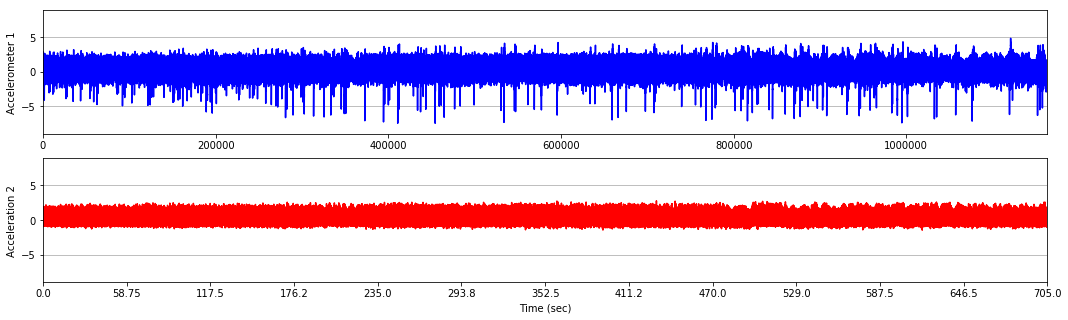

Clipped Data: (1163368, 2) - 705.072 s


In [4]:
SD.loadData(SD.all_clipped_files[13])

In [5]:
SD.segmentData(sec = 1, freq = 1650, overlap_rate = 0)

Segmented Data: (705, 1650, 2)


## 1.1. <font color = red>Issue</font>
- Because of the astype('uint8'), the values were automatically converted to under 255 and generated

In [6]:
SD.starting_points.astype('uint8')

array([  0, 114, 228,  86, 200,  58, 172,  30, 144,   2, 116, 230,  88,
       202,  60, 174,  32, 146,   4, 118, 232,  90, 204,  62, 176,  34,
       148,   6, 120, 234,  92, 206,  64, 178,  36, 150,   8, 122, 236,
        94, 208,  66, 180,  38, 152,  10, 124, 238,  96, 210,  68, 182,
        40, 154,  12, 126, 240,  98, 212,  70, 184,  42, 156,  14, 128,
       242, 100, 214,  72, 186,  44, 158,  16, 130, 244, 102, 216,  74,
       188,  46, 160,  18, 132, 246, 104, 218,  76, 190,  48, 162,  20,
       134, 248, 106, 220,  78, 192,  50, 164,  22, 136, 250, 108, 222,
        80, 194,  52, 166,  24, 138, 252, 110, 224,  82, 196,  54, 168,
        26, 140, 254, 112, 226,  84, 198,  56, 170,  28, 142,   0, 114,
       228,  86, 200,  58, 172,  30, 144,   2, 116, 230,  88, 202,  60,
       174,  32, 146,   4, 118, 232,  90, 204,  62, 176,  34, 148,   6,
       120, 234,  92, 206,  64, 178,  36, 150,   8, 122, 236,  94, 208,
        66, 180,  38, 152,  10, 124, 238,  96, 210,  68, 182,  4

## 1.2. <font color = blue>Revised</font>
- Segmentation starting points generated by window length 1650 (1s) and overlap rate 0 (this is what I originally thought)

In [7]:
SD.starting_points

array([      0,    1650,    3300,    4950,    6600,    8250,    9900,
         11550,   13200,   14850,   16500,   18150,   19800,   21450,
         23100,   24750,   26400,   28050,   29700,   31350,   33000,
         34650,   36300,   37950,   39600,   41250,   42900,   44550,
         46200,   47850,   49500,   51150,   52800,   54450,   56100,
         57750,   59400,   61050,   62700,   64350,   66000,   67650,
         69300,   70950,   72600,   74250,   75900,   77550,   79200,
         80850,   82500,   84150,   85800,   87450,   89100,   90750,
         92400,   94050,   95700,   97350,   99000,  100650,  102300,
        103950,  105600,  107250,  108900,  110550,  112200,  113850,
        115500,  117150,  118800,  120450,  122100,  123750,  125400,
        127050,  128700,  130350,  132000,  133650,  135300,  136950,
        138600,  140250,  141900,  143550,  145200,  146850,  148500,
        150150,  151800,  153450,  155100,  156750,  158400,  160050,
        161700,  163

## 1.3. Preprocessing and Save

In [9]:
valid_idx = [0, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21]

00 - /SEMBLEX_200211/BAD_CONDITIONS/HEAVY_OIL/Logged Data_2020_02_11_raw.npy


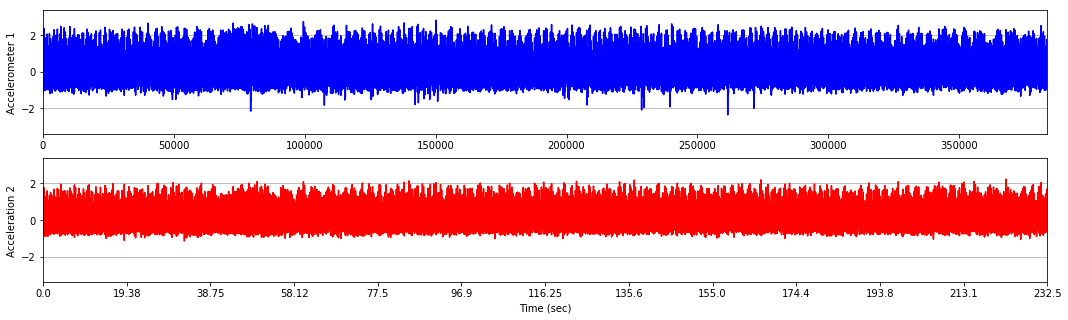

Clipped Data: (383670, 2) - 232.527 s
Segmented Data: (258, 1650, 2)
Wavelet Transform |---------------------------------------------------------------------------------------------------- | 0.4% 

/home/yunseob/Pytorch/lib/python3.5/site-packages/wavelets/transform.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wavelet_data[slices],


Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200211__BAD_CONDITIONS__HEAVY_OIL__WT_1s_1650hz__258_40_40, shape: (258, 40, 40, 2)

05 - /SEMBLEX_200211/BAD_TOOLS/CHIPPED_PUNCH/Logged Data_2020_02_11_raw.npy


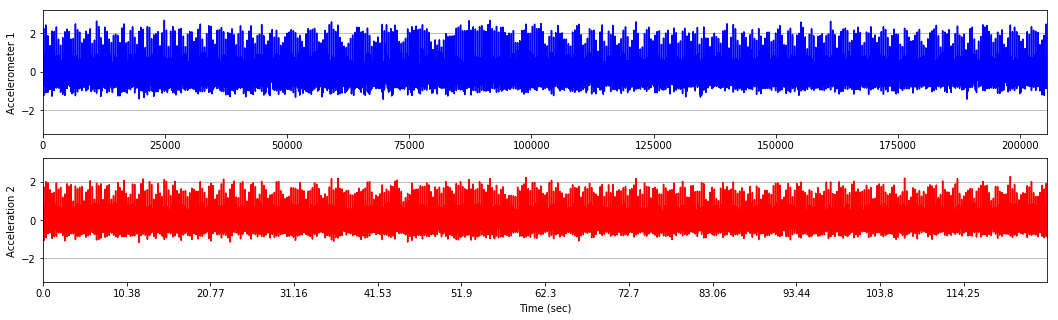

Clipped Data: (205596, 2) - 124.604 s
Segmented Data: (138, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200211__BAD_TOOLS__CHIPPED_PUNCH__WT_1s_1650hz__138_40_40, shape: (138, 40, 40, 2)

07 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_11_raw.npy


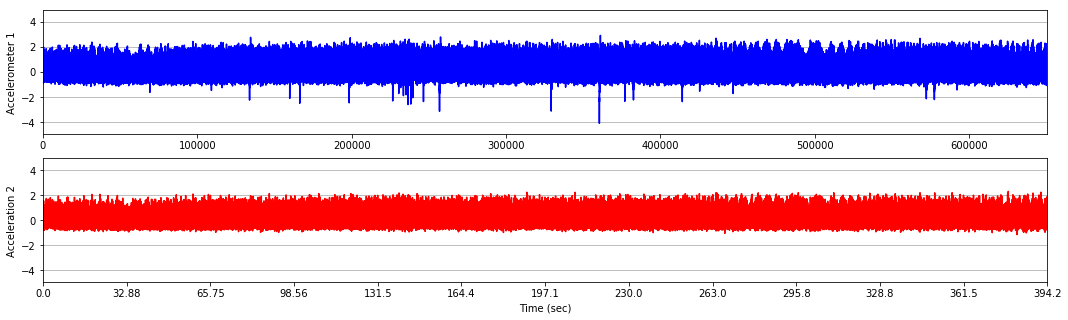

Clipped Data: (650685, 2) - 394.355 s
Segmented Data: (438, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200211__GOOD_DATA__REGULAR__WT_1s_1650hz__438_40_40, shape: (438, 40, 40, 2)

08 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_12_raw.npy


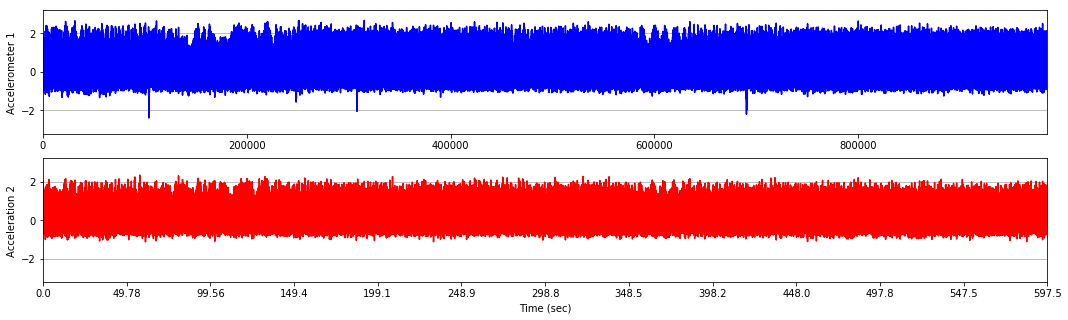

Clipped Data: (985593, 2) - 597.329 s
Segmented Data: (663, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200211__GOOD_DATA__REGULAR__WT_1s_1650hz__663_40_40, shape: (663, 40, 40, 2)

09 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_13_raw.npy


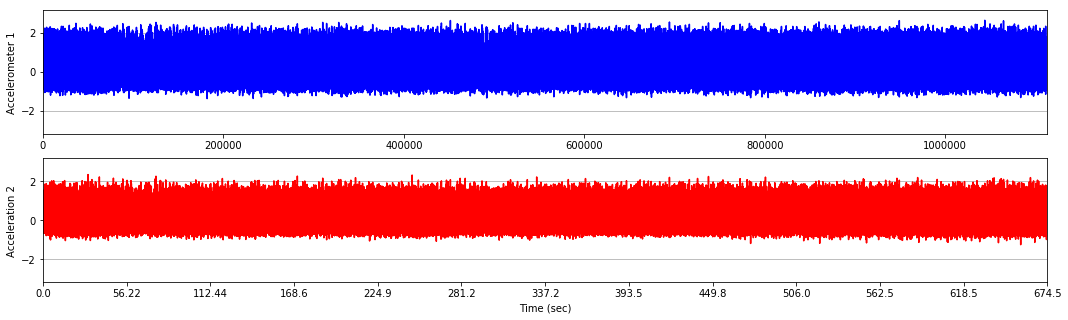

Clipped Data: (1113314, 2) - 674.736 s
Segmented Data: (749, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200211__GOOD_DATA__REGULAR__WT_1s_1650hz__749_40_40, shape: (749, 40, 40, 2)

10 - /SEMBLEX_200211/GOOD_DATA/REGULAR/Logged Data_2020_02_14_raw.npy


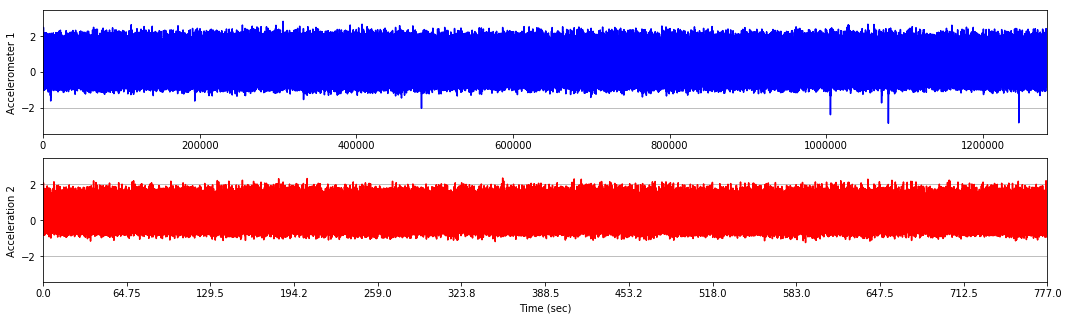

Clipped Data: (1282327, 2) - 777.168 s
Segmented Data: (863, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200211__GOOD_DATA__REGULAR__WT_1s_1650hz__863_40_40, shape: (863, 40, 40, 2)

11 - /SEMBLEX_200212/BAD_MATERIAL/SCRAPPED/Logged Data_2020_02_11_raw.npy


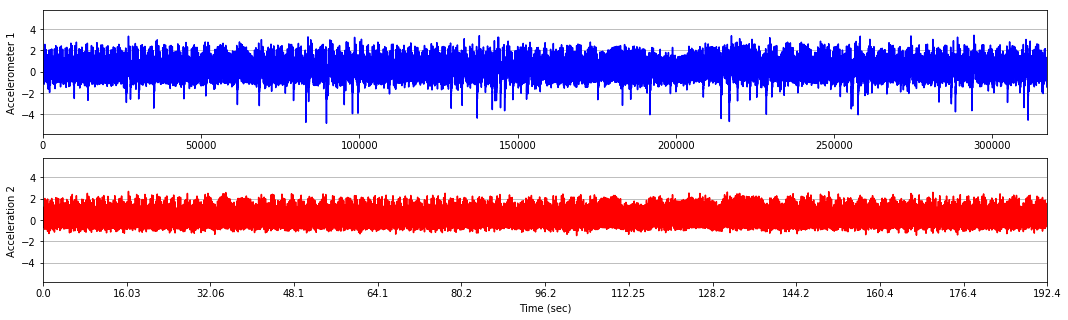

Clipped Data: (317444, 2) - 192.390 s
Segmented Data: (213, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BAD_MATERIAL__SCRAPPED__WT_1s_1650hz__213_40_40, shape: (213, 40, 40, 2)

12 - /SEMBLEX_200212/BAD_MATERIAL/SCRAPPED/Logged Data_2020_02_12_raw.npy


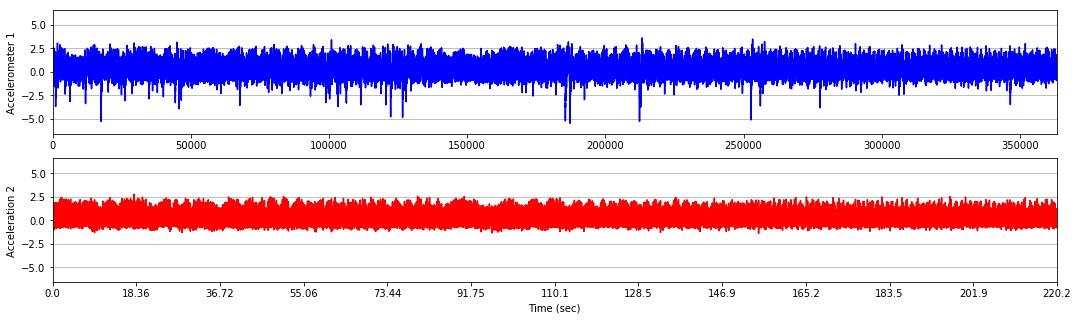

Clipped Data: (363422, 2) - 220.256 s
Segmented Data: (244, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BAD_MATERIAL__SCRAPPED__WT_1s_1650hz__244_40_40, shape: (244, 40, 40, 2)

13 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_DIE_CHIP_TOP_2/Logged Data_2020_02_13_raw.npy


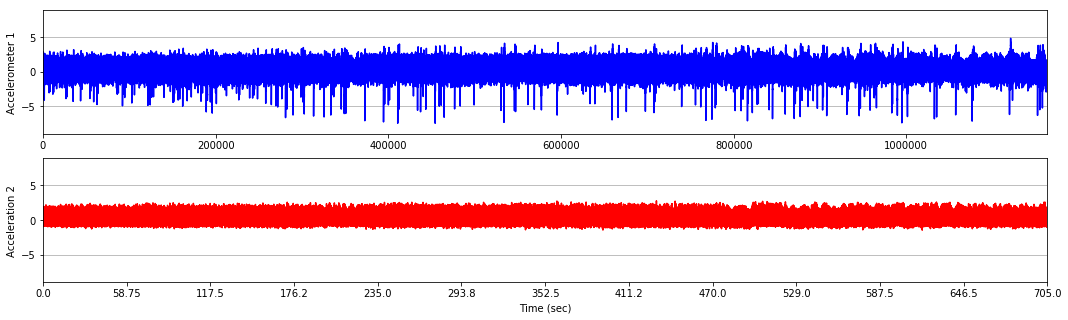

Clipped Data: (1163368, 2) - 705.072 s
Segmented Data: (783, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_DIE_CHIP_TOP_2__WT_1s_1650hz__783_40_40, shape: (783, 40, 40, 2)

14 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_DIE_CHIP_TOP_3/Logged Data_2020_02_13_raw.npy


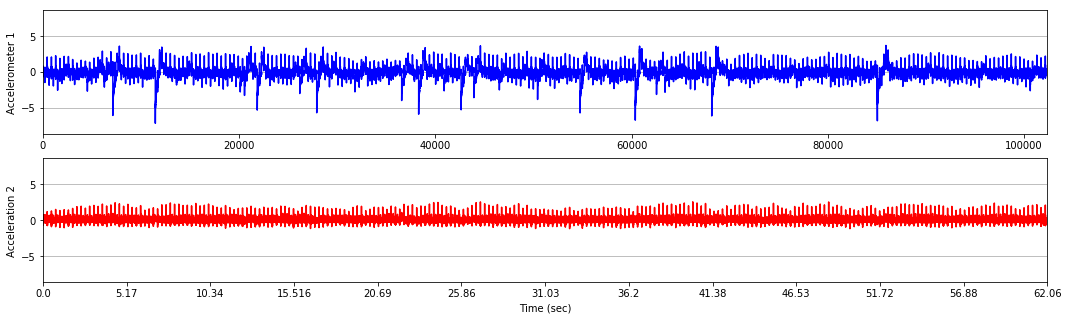

Clipped Data: (102385, 2) - 62.052 s
Segmented Data: (68, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_DIE_CHIP_TOP_3__WT_1s_1650hz__68_40_40, shape: (68, 40, 40, 2)

15 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_DIE_CHIP_TOP_SHORT_FEED/Logged Data_2020_02_13_raw.npy


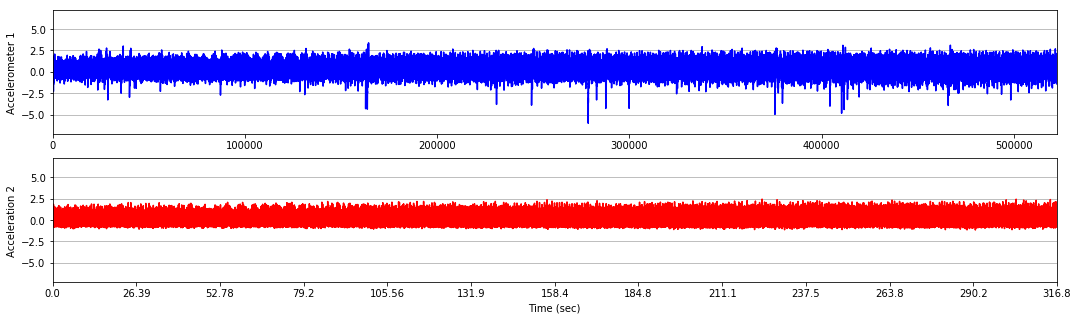

Clipped Data: (522442, 2) - 316.632 s
Segmented Data: (351, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_DIE_CHIP_TOP_SHORT_FEED__WT_1s_1650hz__351_40_40, shape: (351, 40, 40, 2)

16 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_DIE_INTERNAL/Logged Data_2020_02_11_raw.npy


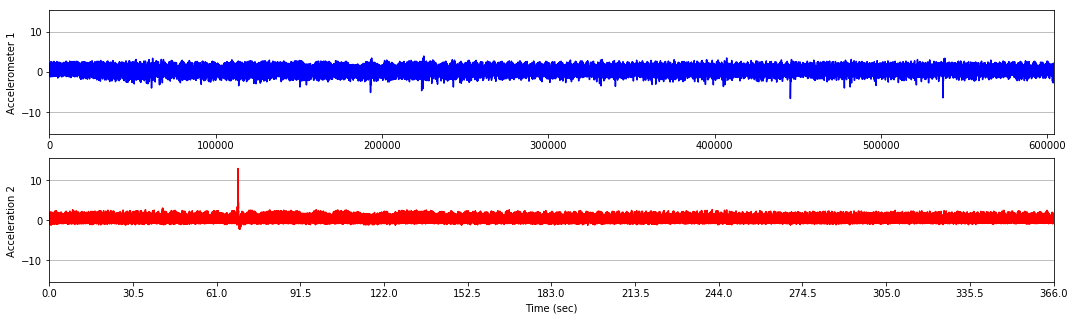

Clipped Data: (603762, 2) - 365.916 s
Segmented Data: (406, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_DIE_INTERNAL__WT_1s_1650hz__406_40_40, shape: (406, 40, 40, 2)

17 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_DIE_INTERNAL/Logged Data_2020_02_12_raw.npy


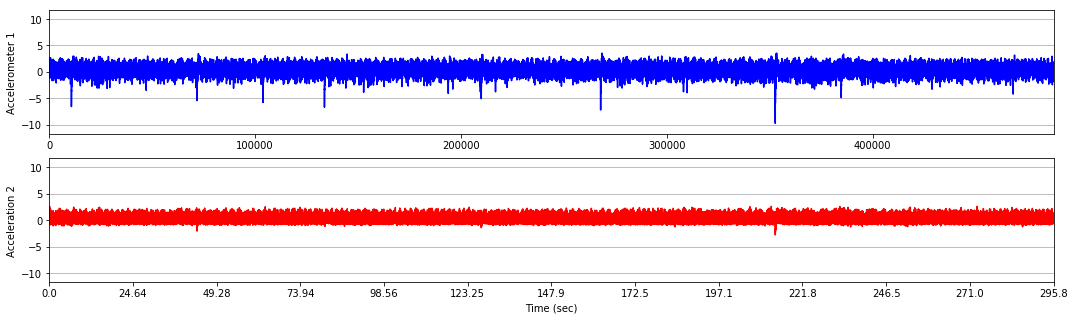

Clipped Data: (487961, 2) - 295.734 s
Segmented Data: (328, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_DIE_INTERNAL__WT_1s_1650hz__328_40_40, shape: (328, 40, 40, 2)

19 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_PIN/Logged Data_2020_02_12_raw.npy


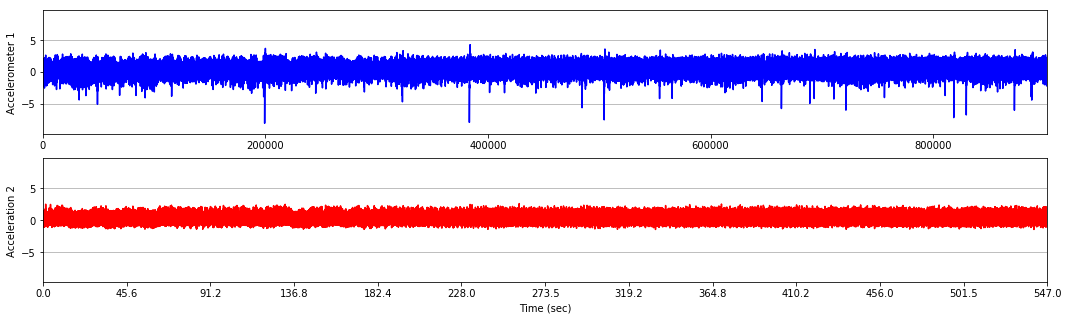

Clipped Data: (902740, 2) - 547.115 s
Segmented Data: (607, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_PIN__WT_1s_1650hz__607_40_40, shape: (607, 40, 40, 2)

20 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_PIN_MACHINE_STOPPED/Logged Data_2020_02_11_raw.npy


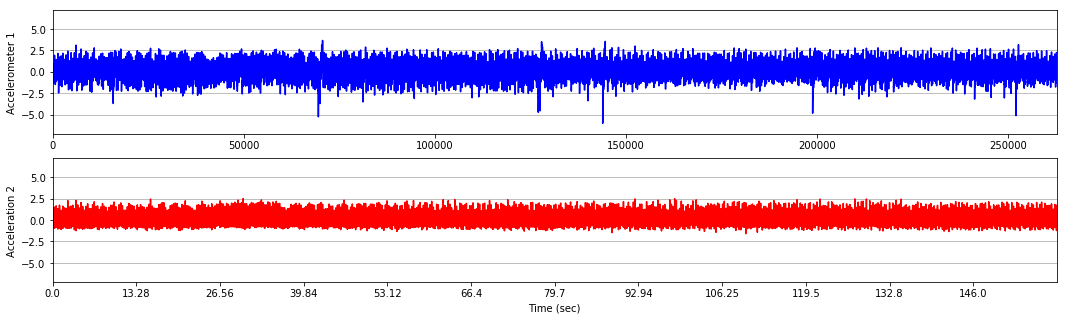

Clipped Data: (262908, 2) - 159.338 s
Segmented Data: (176, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_PIN_MACHINE_STOPPED__WT_1s_1650hz__176_40_40, shape: (176, 40, 40, 2)

21 - /SEMBLEX_200212/BROKEN_TOOLS/BAD_PUNCH/Logged Data_2020_02_11_raw.npy


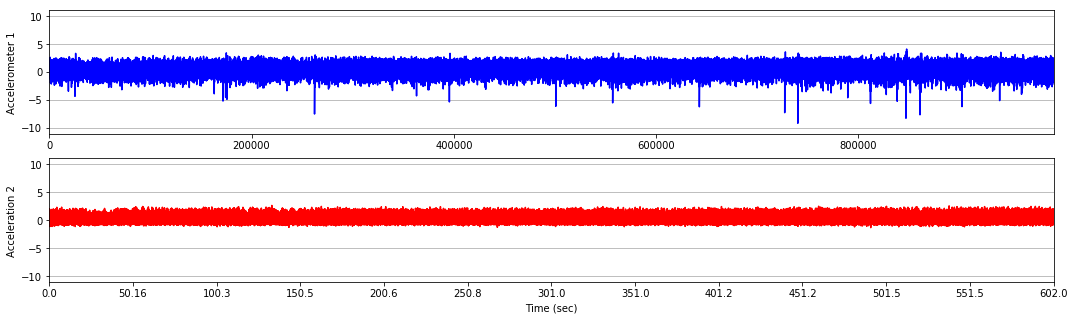

Clipped Data: (992888, 2) - 601.750 s
Segmented Data: (668, 1650, 2)
Wavelet Transform |#################################################################################################### | 100.0% 
Saved: ./SemblexData/wt_4040/SEMBLEX_200212__BROKEN_TOOLS__BAD_PUNCH__WT_1s_1650hz__668_40_40, shape: (668, 40, 40, 2)



In [11]:
save_dir = './SemblexData/wt_4040/'
SD.ProcessingandSaving(valid_idx, sec = 1, freq = 1650, overlap_rate = 0.1, wt_shape = (40, 40), save_dir = save_dir)

In [12]:
SD.starting_points

array([     0,   1485,   2970,   4455,   5940,   7425,   8910,  10395,
        11880,  13365,  14850,  16335,  17820,  19305,  20790,  22275,
        23760,  25245,  26730,  28215,  29700,  31185,  32670,  34155,
        35640,  37125,  38610,  40095,  41580,  43065,  44550,  46035,
        47520,  49005,  50490,  51975,  53460,  54945,  56430,  57915,
        59400,  60885,  62370,  63855,  65340,  66825,  68310,  69795,
        71280,  72765,  74250,  75735,  77220,  78705,  80190,  81675,
        83160,  84645,  86130,  87615,  89100,  90585,  92070,  93555,
        95040,  96525,  98010,  99495, 100980, 102465, 103950, 105435,
       106920, 108405, 109890, 111375, 112860, 114345, 115830, 117315,
       118800, 120285, 121770, 123255, 124740, 126225, 127710, 129195,
       130680, 132165, 133650, 135135, 136620, 138105, 139590, 141075,
       142560, 144045, 145530, 147015, 148500, 149985, 151470, 152955,
       154440, 155925, 157410, 158895, 160380, 161865, 163350, 164835,
      